In [82]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Read the CSV file into a DataFrame
df = pd.read_csv("Ai Trainer.txt", header=None, encoding='utf8', sep='\t')

In [83]:
import pandas as pd
import re

# Function to remove links and collect them in a list
def remove_links_and_collect(text, rejected_links):
    # Regular expression to match URLs
    url_pattern = r'http[s]?://\S+|www\.\S+'
    
    # Find all the URLs in the text
    links = re.findall(url_pattern, text)
    
    # Add the found links to the rejected_links list
    rejected_links.extend(links)
    
    # Remove the links from the text
    text = re.sub(url_pattern, '', text)
    
    return text

# Read your dataset
df = pd.read_csv("Ai Trainer.txt", header=None, encoding='utf8', sep='\t')

# Create an empty list to store rejected links
rejected_links = []

# Apply the remove_links_and_collect function to your DataFrame
df[0] = df[0].apply(lambda text: remove_links_and_collect(text, rejected_links))

# Now, df contains messages with links removed, and rejected_links contains the removed links
print(df.head())
print("\nRejected links:")
print(rejected_links)

                                                   0
0  06/10/23, 12:50 pm - Messages and calls are en...
1            09/10/23, 11:34 am - Ai Trainer: Hi sir
2        09/10/23, 11:34 am - ❤️Vignesh Vs 😘: Hi sir
3  09/10/23, 11:35 am - ❤️Vignesh Vs 😘: <Media om...
4  09/10/23, 11:41 am - Ai Trainer: This message ...

Rejected links:
['https://drive.google.com/drive/folders/1b0Qtlah-3_mYe9GvCgDF98sSgIpK_jjb', 'https://github.com/VigneshS0604/TSA', 'https://github.com/VigneshS0604/NLP', 'https://meet.google.com/wgn-hqvg-ooi', 'https://www.canva.com/design/DAFyPoOv_CY/d1bw2r88cs101EaCT8BOKQ/edit?locale=en&ui=eyJHIjp7IkUiOnRydWV9fQ&layoutQuery=resu', 'https://github.com/VigneshS0604/DL-helmet-detector']


In [84]:
# Initialize an instance of the SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Initialize empty lists to store the extracted values
dates = []
times = []
names = []
messages = []
sentiments = []  # New list for sentiment predictions

# Iterate through each row in the DataFrame
for text in df[0]:  # Assuming the message column is in the first column (0-indexed)
    # Split the text by " - " to extract the date and time
    parts = text.split(' - ', 1)

    # Check if the split produced two parts
    if len(parts) == 2:
        date_time = parts[0]
        date, time = date_time.split(', ', 1)
        message = parts[1]

        # Split the message by ": " to separate the name and message
        if ": " in message:
            name, message = message.split(": ", 1)
        else:
            # Set a default name when splitting is not possible
            name = "Ai Trainer"

        # Analyze sentiment of the message
        sentiment = analyzer.polarity_scores(message)['compound']

        # Append the extracted values to the lists
        dates.append(date)
        times.append(time)
        names.append(name)
        messages.append(message)
        sentiments.append(sentiment)

    else:
        # Handle the case where the split didn't produce two parts
        # You can choose to skip, print a message, or handle it as needed
        pass

# Ensure that the lengths of the lists match the length of the index
expected_length = len(df)
while len(dates) < expected_length:
    dates.append('')
    times.append('')
    names.append('Ai Trainer')
    messages.append('')
    sentiments.append(0.0)  # Default sentiment score

# Create new columns in the DataFrame for date, time, name, message, and sentiment
df['Date'] = dates
df['Time'] = times
df['Name'] = names
df['Message'] = messages
df['Sentiment'] = sentiments

# Print the DataFrame with separated columns
df=df[['Date', 'Time', 'Name', 'Message', 'Sentiment']]
df


,Date,Time,Name,Message,Sentiment
0,06/10/23,12:50 pm,Ai Trainer,Messages and calls are end-to-end encrypted. N...,-0.2960
1,09/10/23,11:34 am,Ai Trainer,Hi sir,0.0000
2,09/10/23,11:34 am,❤️Vignesh Vs 😘,Hi sir,0.0000
3,09/10/23,11:35 am,❤️Vignesh Vs 😘,<Media omitted>,0.0000
4,09/10/23,11:41 am,Ai Trainer,This message was deleted,0.0000
...,...,...,...,...,...
142,30/10/23,6:56 pm,❤️Vignesh Vs 😘,Soo free ya erutha call me sir,0.5106
143,30/10/23,11:10 pm,Ai Trainer,Tomorrow I will call you bro,0.0000
144,,,Ai Trainer,,0.0000
145,,,Ai Trainer,,0.0000


In [85]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming you have a DataFrame 'df' with columns 'Message' and 'Sentiment'

# Assuming 'Sentiment' column contains continuous scores, convert them to labels
def convert_to_sentiment_label(sentiment_score):
    if sentiment_score > 0.2:
        return 'positive'
    elif sentiment_score < -0.2:
        return 'negative'
    else:
        return 'neutral'

# Apply the conversion function to create a new 'Sentiment_Label' column
df['Sentiment_Label'] = df['Sentiment'].apply(convert_to_sentiment_label)

# Use Count Vectorization to convert text into numerical features
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Message'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Sentiment_Label'], test_size=0.2, random_state=42)

# Initialize and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict sentiment on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


Accuracy: 0.9666666666666667
Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         1
     neutral       0.96      1.00      0.98        26
    positive       1.00      1.00      1.00         3

    accuracy                           0.97        30
   macro avg       0.65      0.67      0.66        30
weighted avg       0.93      0.97      0.95        30



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
# Categorize messages
def categorize_message(sentiment):
    if sentiment > 0.2:
        return "Flirt Encounters"
    elif sentiment > 0:
        return "Talkative"
    elif sentiment == 0:
        return "Less Talkative"
    else:
        return "Neutral"

df['Category'] = df['Sentiment'].apply(categorize_message)

# Create a pivot table to calculate percentages by name
pivot_name = pd.pivot_table(df, index='Name', columns='Category', aggfunc='size', fill_value=0)

# Calculate percentages for each category
total_name = pivot_name.sum(axis=1)
total_name_percentage = (pivot_name / total_name.values.reshape(-1, 1)) * 100

# Print the DataFrame with separated columns and percentages
#print(df[['Date', 'Time', 'Name', 'Message', 'Sentiment', 'Category']])
#print("\nPercentage by Name:")
total_name_percentage


Category,Flirt Encounters,Less Talkative,Neutral
Name,,,
Ai Trainer,18.644068,77.966102,3.389831
❤️Vignesh Vs 😘,7.954545,87.500000,4.545455


In [87]:
# Create new columns in the DataFrame for date, time, name, message, and sentiment
df['Date'] = dates
df['Time'] = times
df['Name'] = names
df['Message'] = messages
df['Sentiment'] = sentiments

# Categorize messages
def categorize_message(sentiment):
    if sentiment > 0.2:
        return "Flirt Encounters"
    elif sentiment > 0:
        return "Talkative"  # Add a category for messages with positive sentiment but not flirting
    elif sentiment == 0:
        return "Less Talkative"
    else:
        return "Neutral"

df['Category'] = df['Sentiment'].apply(categorize_message)

# Create a pivot table to calculate flirt percentages by name and date
pivot_name = pd.pivot_table(df, index='Name', columns='Category', aggfunc='size', fill_value=0)
#pivot_date = pd.pivot_table(df, index='Date', columns='Category', aggfunc='size', fill_value=0)

# Calculate percentages
total_name = pivot_name.sum(axis=1)
#total_date = pivot_date.sum(axis=1)

pivot_name_percentage = (pivot_name / total_name.values.reshape(-1, 1)) * 100
# Print the DataFrame with separated columns and percentages
#print(df[['Date', 'Time', 'Name', 'Message', 'Sentiment', 'Category']])
#print("\nFlirt Percentage by Name:")
pivot_name_percentage
#pivot_name_percentage
#print("\nFlirt Percentage by Date:")
#print(pivot_date_percentage)

Category,Flirt Encounters,Less Talkative,Neutral
Name,,,
Ai Trainer,18.644068,77.966102,3.389831
❤️Vignesh Vs 😘,7.954545,87.500000,4.545455


In [88]:
# Convert the "Date" column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%y/%m/%d')

# Format the "Date" column to display the day name
df['DayName'] = df['Date'].dt.strftime('%A')

# Group by DayName and calculate the number of messages per day
daily_message_counts = df.groupby('DayName').size().reset_index(name='MessageCount')

# Calculate the "Most Active Day" by finding the day with the highest message count
most_active_day = daily_message_counts.loc[daily_message_counts['MessageCount'].idxmax()]

# Format the "Hour" column to display the time
df['Time'] = pd.to_datetime(df['Time']).dt.strftime('%I:%M')

# Group by Time and calculate the number of messages per time
hourly_message_counts = df.groupby('Time').size().reset_index(name='MessageCount')
#hourly_message_counts = hourly_message_counts.drop(columns=['MessageCount'])

# Calculate the "Most Active Hour" by finding the time with the highest message count
most_active_hour = hourly_message_counts.loc[hourly_message_counts['MessageCount'].idxmax()]

# Calculate the "Average Number of Messages per Day"
average_messages_per_day = int(daily_message_counts['MessageCount'].mean())


# Assuming you have the variables most_active_day, most_active_hour, and average_messages_per_day
data = {
    'Most Active Day': [most_active_day],
    'Most Active Hour': [most_active_hour],
    'Average Number of Messages per Day': [average_messages_per_day]
}

Most = pd.DataFrame(data)
Most
#print("Most Active Day:", most_active_day)
#print("\nMost Active Hour:", most_active_hour)
#print("\nAverage Number of Messages per Day:", average_messages_per_day)

C:\Users\hp5cd\AppData\Local\Temp\ipykernel_8072\1055457135.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.strftime('%I:%M')


,Most Active Day,Most Active Hour,Average Number of Messages per Day
0,DayName Friday MessageCount 48 ...,Time 05:33 MessageCount 7 Na...,20


In [89]:
# Initialize counters for different types of entries
media_count = 0
deleted_message_count = 0
missed_voice_call_count = 0
missed_video_call_count = 0

# Create dictionaries to store counts for each person
media_counts_by_person = {}
deleted_message_counts_by_person = {}
missed_voice_call_counts_by_person = {}
missed_video_call_counts_by_person = {}

# Iterate through each message to count specific entries
for name, message in zip(df['Name'], df['Message']):
    if "Media omitted" in message:
        media_count += 1
        if name in media_counts_by_person:
            media_counts_by_person[name] += 1
        else:
            media_counts_by_person[name] = 1
    if "This message was deleted" in message:
        deleted_message_count += 1
        if name in deleted_message_counts_by_person:
            deleted_message_counts_by_person[name] += 1
        else:
            deleted_message_counts_by_person[name] = 1
    if "missed voice call" in message:
        missed_voice_call_count += 1
        if name in missed_voice_call_counts_by_person:
            missed_voice_call_counts_by_person[name] += 1
        else:
            missed_voice_call_counts_by_person[name] = 1
    if "missed video call" in message:
        missed_video_call_count += 1
        if name in missed_video_call_counts_by_person:
            missed_video_call_counts_by_person[name] += 1
        else:
            missed_video_call_counts_by_person[name] = 1

# Print the total counts
print("Total Media Encounters:", media_count)
print("Total Deleted Message Count:", deleted_message_count)
print("Total Missed Voice Call Count:", missed_voice_call_count)
print("Total Missed Video Call Count:", missed_video_call_count)

data = {
    'Media Encounters by Person': media_counts_by_person,
    'Deleted Message Count by Person': deleted_message_counts_by_person,
    'Missed Voice Call Count by Person': missed_voice_call_counts_by_person,
    'Missed Video Call Count by Person': missed_video_call_counts_by_person,
}
Media = pd.DataFrame(data)
Media


Total Media Encounters: 69
Total Deleted Message Count: 1
Total Missed Voice Call Count: 0
Total Missed Video Call Count: 0


,Media Encounters by Person,Deleted Message Count by Person,Missed Voice Call Count by Person,Missed Video Call Count by Person
❤️Vignesh Vs 😘,37,NaN,NaN,NaN
Ai Trainer,32,1.0,NaN,NaN


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             144 non-null    datetime64[ns]
 1   Time             144 non-null    object        
 2   Name             147 non-null    object        
 3   Message          147 non-null    object        
 4   Sentiment        147 non-null    float64       
 5   Sentiment_Label  147 non-null    object        
 6   Category         147 non-null    object        
 7   DayName          144 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 9.3+ KB


In [91]:
dataset=df

In [92]:
dataset.dropna(inplace=True)

In [93]:
sid = SentimentIntensityAnalyzer()

In [94]:
senti=sid.polarity_scores(dataset['Message'][4])

In [95]:
senti

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [96]:
 def sentimentalAnalysis(data,columnname):
        
        #downloading vader_lexicon for the process
        import matplotlib.pyplot as plt
        import seaborn as sns
        "Importing Necessary Packeage"
        from nltk.sentiment.vader import SentimentIntensityAnalyzer
        sid = SentimentIntensityAnalyzer()
        
        "Deleting null pr empty value"
        data.dropna(inplace=True)
        
        "Checking for a comment"
        #sid.polarity_scores(data[columnname][93])
        
        "Creating respective columns"
        
        data['scores'] = data[columnname].apply(lambda commentText: sid.polarity_scores(commentText))
        data['compound']  = data['scores'].apply(lambda score_dict: score_dict['compound'])
        data['Negtive']  = data['scores'].apply(lambda score_dict: score_dict['neg'])
        data['Postive']  = data['scores'].apply(lambda score_dict: score_dict['pos'])
        data['Neutral']  = data['scores'].apply(lambda score_dict: score_dict['neu'])
        
        "Creating final pos or neg using compound score"
        data['comp_score'] = data['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')
        plt.clf()
        #comp=sns.countplot(x = 'comp_score', hue = 'Name', data = data, palette = 'magma')
        #comp.figure.savefig("date_charts.png")
        "Checking how many pos and neg"
        posneg=pd.DataFrame(data['comp_score'].value_counts())
        return posneg,data
    

In [97]:
pos,data_Senti=sentimentalAnalysis(dataset,columnname='Message')

<Figure size 640x480 with 0 Axes>

In [98]:
data_Senti

,Date,Time,Name,Message,Sentiment,Sentiment_Label,Category,DayName,scores,compound,Negtive,Postive,Neutral,comp_score
0,2006-10-23,12:50,Ai Trainer,Messages and calls are end-to-end encrypted. N...,-0.2960,negative,Neutral,Monday,"{'neg': 0.084, 'neu': 0.916, 'pos': 0.0, 'comp...",-0.2960,0.084,0.000,0.916,neg
1,2009-10-23,11:34,Ai Trainer,Hi sir,0.0000,neutral,Less Talkative,Friday,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos
2,2009-10-23,11:34,❤️Vignesh Vs 😘,Hi sir,0.0000,neutral,Less Talkative,Friday,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos
3,2009-10-23,11:35,❤️Vignesh Vs 😘,<Media omitted>,0.0000,neutral,Less Talkative,Friday,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos
4,2009-10-23,11:41,Ai Trainer,This message was deleted,0.0000,neutral,Less Talkative,Friday,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2030-10-23,06:55,❤️Vignesh Vs 😘,<Media omitted>,0.0000,neutral,Less Talkative,Wednesday,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos
140,2030-10-23,06:55,❤️Vignesh Vs 😘,,0.0000,neutral,Less Talkative,Wednesday,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,0.000,pos
141,2030-10-23,06:56,❤️Vignesh Vs 😘,Sir yannaku doubt eruku,-0.3612,negative,Neutral,Wednesday,"{'neg': 0.455, 'neu': 0.545, 'pos': 0.0, 'comp...",-0.3612,0.455,0.000,0.545,neg
142,2030-10-23,06:56,❤️Vignesh Vs 😘,Soo free ya erutha call me sir,0.5106,positive,Flirt Encounters,Wednesday,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.5106,0.000,0.355,0.645,pos


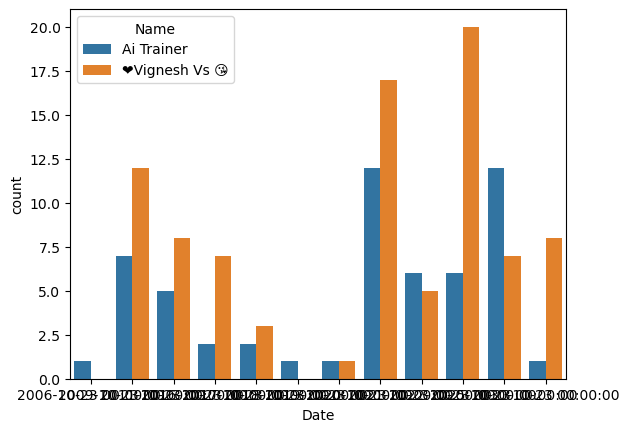

In [99]:
import seaborn as sb
import matplotlib.pyplot as plt
# Import matplotlib.pyplot
sb.countplot(x='Date',data=dataset,hue='Name')
plt.show()

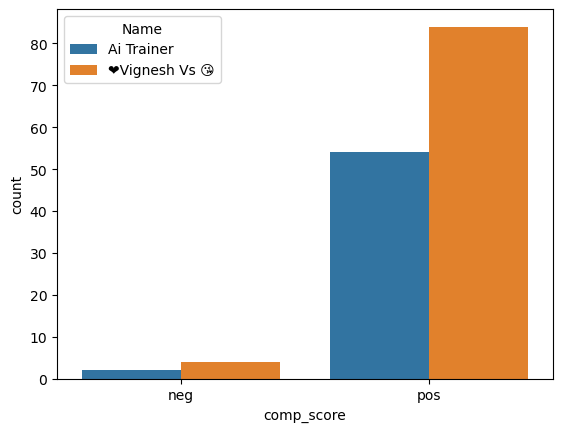

In [100]:
import seaborn as sb
sb.countplot(x='comp_score',data=dataset,hue='Name')
plt.show()

In [101]:
pos

,count
comp_score,
pos,138
neg,6


In [102]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [104]:
tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')
dtm=tfidf.fit_transform(df["Message"])

In [105]:
from sklearn.decomposition import NMF
nmf_model=NMF(n_components=5,random_state=42)
nmf_model.fit(dtm)

NMF(n_components=5, random_state=42)

In [61]:
for index, topic in enumerate(nmf_model.components_):
    results = [tfidf.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    print(results)

['ya', 'tha', 'work', 'thriyala', 'problem', 'time', 'yannaku', 'panna', 'media', 'omitted']
['check', 'doubt', 'nu', 'na', 'okk', 'run', 'eruku', 'hi', 'ok', 'sir']
['yannaku', 'panni', 'update', 'kindly', 'send', 'illa', 'tomorrow', 'check', 'ok', 'bro']
['kindly', 'learning', 'hi', 'yannaku', 'correct', 'update', 'ok', 'check', 'deleted', 'message']
['resume', 'work', 'tomorrow', 'thriyala', 'problem', 'panna', 'sir', 'soo', 'ya', 'free']


In [62]:
topic_results=nmf_model.transform(dtm)
df["Topic"]=topic_results.argmax(axis=1)

In [63]:
df

,Date,Time,Name,Message,Sentiment,Sentiment_Label,Category,DayName,scores,compound,Negtive,Postive,Neutral,comp_score,Topic
0,2006-10-23,12:50,Ai Trainer,Messages and calls are end-to-end encrypted. N...,-0.2960,negative,Neutral,Monday,"{'neg': 0.084, 'neu': 0.916, 'pos': 0.0, 'comp...",-0.2960,0.084,0.000,0.916,neg,0
1,2009-10-23,11:34,Ai Trainer,Hi sir,0.0000,neutral,Less Talkative,Friday,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos,1
2,2009-10-23,11:34,❤️Vignesh Vs 😘,Hi sir,0.0000,neutral,Less Talkative,Friday,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos,1
3,2009-10-23,11:35,❤️Vignesh Vs 😘,<Media omitted>,0.0000,neutral,Less Talkative,Friday,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos,0
4,2009-10-23,11:41,Ai Trainer,This message was deleted,0.0000,neutral,Less Talkative,Friday,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2030-10-23,06:55,❤️Vignesh Vs 😘,<Media omitted>,0.0000,neutral,Less Talkative,Wednesday,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,1.000,pos,0
140,2030-10-23,06:55,❤️Vignesh Vs 😘,,0.0000,neutral,Less Talkative,Wednesday,"{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.0000,0.000,0.000,0.000,pos,0
141,2030-10-23,06:56,❤️Vignesh Vs 😘,Sir yannaku doubt eruku,-0.3612,negative,Neutral,Wednesday,"{'neg': 0.455, 'neu': 0.545, 'pos': 0.0, 'comp...",-0.3612,0.455,0.000,0.545,neg,1
142,2030-10-23,06:56,❤️Vignesh Vs 😘,Soo free ya erutha call me sir,0.5106,positive,Flirt Encounters,Wednesday,"{'neg': 0.0, 'neu': 0.645, 'pos': 0.355, 'comp...",0.5106,0.000,0.355,0.645,pos,4


In [64]:
df["Topic"].value_counts()

Topic
0    90
1    22
2    15
4    12
3     5
Name: count, dtype: int64

In [65]:
dataset=df
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp5cd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

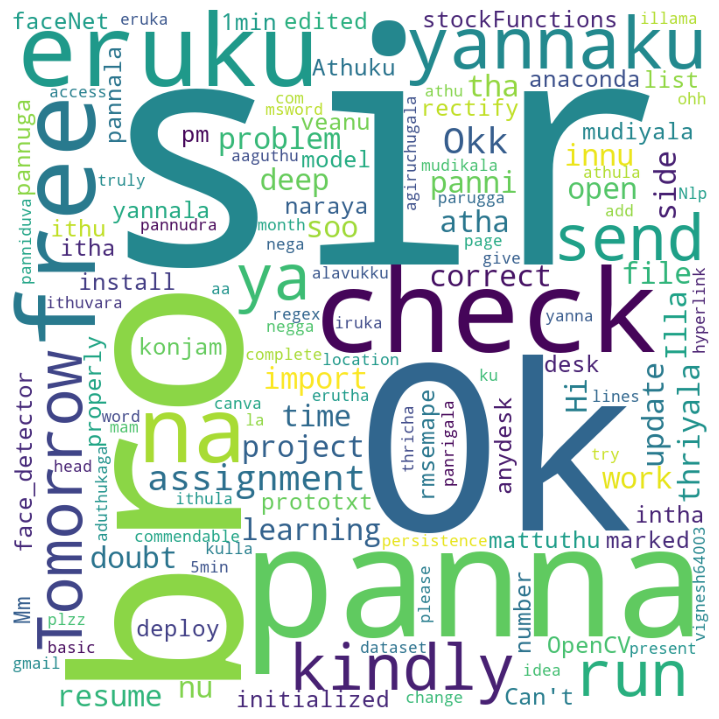

Successfully created


In [67]:

comment_words = []
stoplist = stopwords.words('english')
stoplist.extend(['omitted', 'voice','missed','call','video','deleted','media','message'])
wordcloudss="This function saves image"
dataset.index=range(dataset.shape[0])
for i in range(1,len(dataset)): 
    comment_words.append(dataset['Message'][i])
    vv=" ".join(comment_words)          
    wordcloud = WordCloud(width = 800, height = 800, 
                                background_color ='white', 
                                      stopwords = stoplist, 
                                      min_font_size = 10).generate(vv)         
plt.figure(figsize = (9, 7), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('wordcloud.PNG')
plt.show() 
print("Successfully created")
wordcloudss="This function saves image"
